# Train Models Notebook

This notebook trains the different models that will be compared using the data from the ISIC 2017 challenge. The models that will be trained are:

- Unet (Baseline)
- Attention Unet
- R2Unet
- Attention R2Unet
- TransUnet

In [1]:
# !pip install torch==2.3.0 torchaudio==2.3.0 torchvision==0.18.0
# !pip install albumentations numpy pandas scikit_learn kaggle
# !pip install resnest geffnet opencv-python pretrainedmodels tqdm Pillow packaging

In [2]:
# pip install -i https://test.pypi.org/simple/ melanoma-segmentation==1.1.2

In [ ]:
from melanoma_segmentation.configs.config_setting import CONFIG
from melanoma_segmentation.models.unet import UNet
from melanoma_segmentation.models.attention_unet import AttUNet
from melanoma_segmentation.models.trans_unet import TransUNet
from melanoma_segmentation.models.residual_recurrent_unet import R2UNet
from melanoma_segmentation.results.plots import plot_img_mask_pred
from melanoma_segmentation.utils.preparation_tools import prepare_datasets

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:

base_dir = CONFIG["base_dir"]
image_folder = CONFIG["image_folder"]
gt_folder = CONFIG["gt_folder"]
model_name = CONFIG["model_name"]
split_train = CONFIG["split_train"]
split_val = CONFIG["split_val"]
split_test = CONFIG["split_test"]
image_size = 128
batch_size = CONFIG["batch_size"]
model_path = CONFIG["model_path"]
device = CONFIG["device"]

CONFIG_FINAL = CONFIG

In [5]:
# from google.colab import drive, files
# drive.mount('/content/drive')

CONFIG_DRIVE = CONFIG.copy()
#CONFIG_DRIVE["base_dir"] = "/content/drive/MyDrive/melanoma-segmentation-and-classification/data/"
CONFIG_DRIVE["image_folder"] = image_folder
CONFIG_DRIVE["gt_folder"] = gt_folder
CONFIG_DRIVE["model_name"] = model_name
CONFIG_DRIVE["split_train"] = split_train
CONFIG_DRIVE["split_val"] = split_val
CONFIG_DRIVE["split_test"] = split_test
CONFIG_DRIVE['image_size'] = image_size
CONFIG_DRIVE["batch_size"] = batch_size
CONFIG_DRIVE["model_path"] = model_path
CONFIG_DRIVE["device"] = device
CONFIG_FINAL = CONFIG_DRIVE

In [ ]:
# Recieve the image and ground truth paths change
train_dataset, val_dataset, test_dataset = prepare_datasets(CONFIG_FINAL, train_transform_type="train")

# Get the train test and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

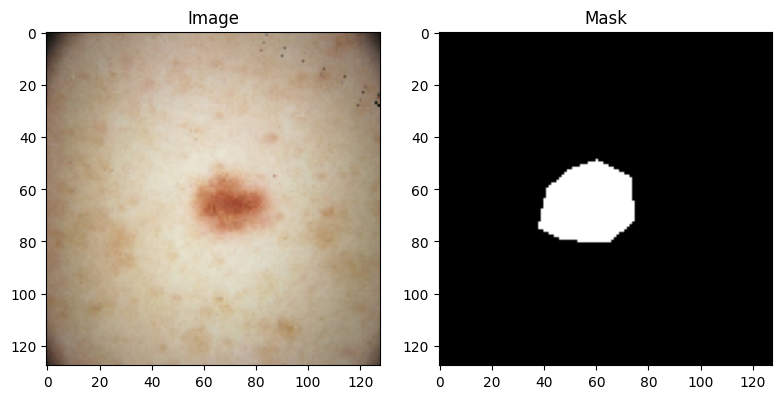

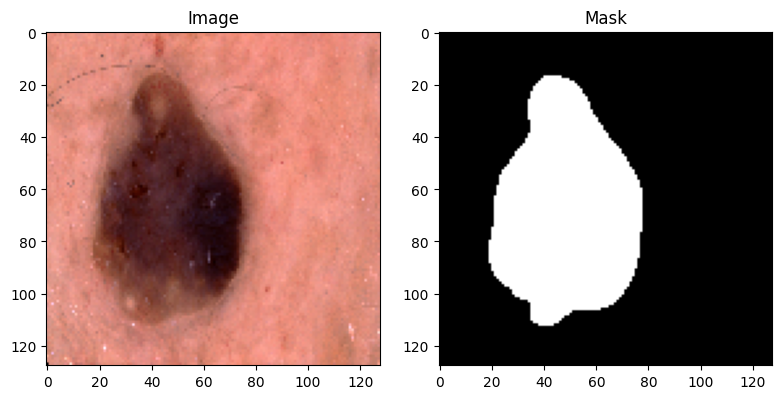

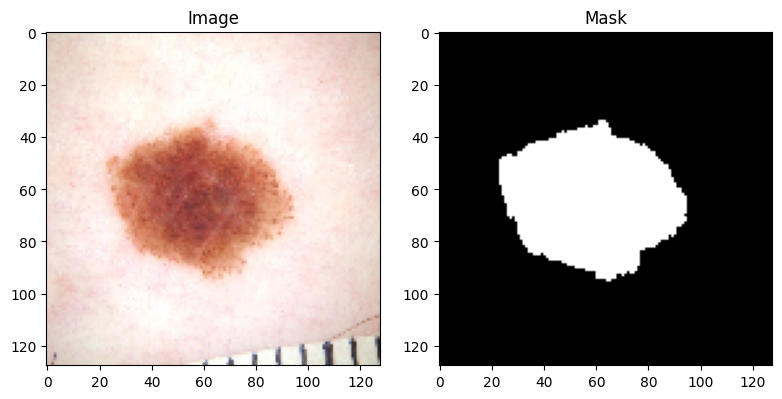

In [7]:
plot_img_mask_pred(train_dataset)
plot_img_mask_pred(val_dataset)
plot_img_mask_pred(test_dataset)


# Train Model

In [8]:
!nvidia-smi

Mon Oct 28 16:44:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:2B:00.0  On |                  N/A |
| 23%   38C    P8             10W /   75W |    1736MiB /   4096MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
model = TransUNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() >= 1:
    print("Using", torch.cuda.device_count(), "GPUs.")
    model = torch.nn.DataParallel(model)
    model.cuda()
# Check if the model is on the GPU



In [10]:
# Print amount of images in each dataset

print(f"Train dataset: {len(train_dataset)} images")
print(f"Val dataset: {len(val_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")

Train dataset: 1620 images
Val dataset: 180 images
Test dataset: 200 images


In [ ]:
import torch.optim as optim
import torch.nn as nn
import time

# Define Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Define early stopping parameters
patience = 3  # Number of epochs to wait for improvement
min_delta = 1e-4  # Minimum improvement in the loss to be considered
best_loss = float('inf')
counter = 0  # Count epochs with no improvement
max_epochs = 50  # Maximum number of epochs to run

# Track the start time for timed stopping (if needed)
start_time = time.time()

# Train the model
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for i, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")

    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch} - Average Loss: {avg_loss}")

    # Check for early stopping based on loss improvement
    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        counter = 0  # Reset counter if there's improvement
        print(f"Loss improved to {best_loss}, resetting patience counter.")
    else:
        counter += 1
        print(f"No improvement in loss. Patience counter: {counter}/{patience}")

    # If patience is exceeded, stop training
    if counter >= patience:
        print(f"Stopping early after {epoch} epochs due to lack of improvement.")
        break

# Save the model
torch.save(model.state_dict(), "unet_256_aug.pth")
# files.download("attunet_512_aug.pth")

Epoch: 0, Batch: 0, Loss: 0.7159613370895386


In [ ]:
# import torch.optim as optim
# import torch.nn as nn
# import time

# # Define Optimizer and Loss Function
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# criterion = lambda y_pred, y_true: nn.BCEWithLogitsLoss()(y_pred, y_true) + DiceLoss()(y_pred, y_true)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# # Define early stopping parameters
# patience = 3  # Number of epochs to wait for improvement
# min_delta = 1e-4  # Minimum improvement in the loss to be considered
# best_val_loss = float('inf')
# counter = 0  # Count epochs with no improvement
# max_epochs = 20  # Maximum number of epochs to run

# # Track the start time for timed stopping (if needed)
# start_time = time.time()

# # Train the model
# for epoch in range(max_epochs):
#     model.train()
#     epoch_loss = 0
#     for i, (images, masks) in enumerate(train_dataloader):
#         images = images.to(device)
#         masks = masks.to(device).float()
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, masks)
#         loss.backward()
        
#         # Apply gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
#         optimizer.step()

#         epoch_loss += loss.item()

#         if i % 10 == 0:
#             print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")

#     # Average loss for the epoch
#     avg_train_loss = epoch_loss / len(train_dataloader)
#     print(f"Epoch {epoch} - Average Training Loss: {avg_train_loss}")

#     # Validation phase
#     model.eval()
#     with torch.no_grad():
#         val_loss = 0
#         for images, masks in val_dataloader:
#             images = images.to(device)
#             masks = masks.to(device).float()
#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             val_loss += loss.item()
#         avg_val_loss = val_loss / len(val_dataloader)
#         print(f"Epoch {epoch} - Average Validation Loss: {avg_val_loss}")

#     # Check for early stopping based on validation loss improvement
#     scheduler.step(avg_val_loss)  # Adjust learning rate if validation loss plateaus

#     if avg_val_loss < best_val_loss - min_delta:
#         best_val_loss = avg_val_loss
#         counter = 0  # Reset counter if there's improvement
#         print(f"Validation Loss improved to {best_val_loss}, resetting patience counter.")
#         torch.save(model.state_dict(), "best_model.pth")  # Save the best model
#     else:
#         counter += 1
#         print(f"No improvement in validation loss. Patience counter: {counter}/{patience}")

#     # If patience is exceeded, stop training
#     if counter >= patience:
#         print(f"Stopping early after {epoch} epochs due to lack of improvement.")
#         break

# # Save the final model
# torch.save(model.state_dict(), "final_model.pth")


In [ ]:
model